In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds

from DDELFI import DDELFI

from delfi.simulator.BaseSimulator import BaseSimulator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from delfi.utils.viz import plot_pdf

from tqdm import tqdm_notebook as tqdm

from parameters import ParameterSet

%matplotlib notebook

In [2]:
class ShapeModel(BaseSimulator):
    def __init__(self, f, sigma, ndim, seed=None):
        super().__init__(dim_param=ndim, seed=seed)
        self.f = f
        
        self.sigma = sigma
        
    def gen_single(self, params):
        m = self.f(params)
        draw = self.rng.normal(loc=m, scale=self.sigma, size=(1,))
        return { 'data' : draw }
    
class ShapeDistribution(dd.BaseDistribution.BaseDistribution):
    def __init__(self, f, sm, obs_stats, seed=None):
        super().__init__(sm.dim_param, seed=seed)
        self.f = f
        self.sm = sm
        self.obs_stats = obs_stats
        self.m = np.linalg.norm(obs_stats)
        self.sigma = sm.sigma
        
    def eval(self, params, log=True):
        logl = -0.5 * np.log(2 * np.pi * self.sigma) -0.5 * ([self.f(param) for param in params] - self.m) ** 2 / (self.sigma ** 2)
        return logl if log else np.exp(logl)

In [3]:
def plot_pdf_2d(params, dist, label = None):
    lims = 2 * np.linalg.norm(params.obs_stats)
    xlist = np.linspace(-lims, lims, 80)
    ylist = np.linspace(-lims, lims, 80)
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111, projection='3d')
    
    X, Y = np.meshgrid(xlist, ylist)
    xys = np.asarray((X.ravel(), Y.ravel())).T
    
    if label is not None:
        fig.suptitle(label)
        
    Z = dist.eval(xys, log=False).reshape(X.shape)
    ax.plot_surface(X, Y, Z, cmap=cm.plasma, rstride=1, cstride=1, linewidth=0, antialiased=False)
        
    ax.set_xlabel("$\\theta_1$")
    ax.set_ylabel("$\\theta_2$")
    ax.set_zlabel("$p(\\theta)$")
    plt.show()
    
    return fig

In [11]:
def run_SNPE(params):
    m = ShapeModel(params.f, sigma=params.sigma, ndim=params.ndim, seed=params.seed)
    p = dd.Uniform(-params.prior_width * np.ones(params.ndim), params.prior_width * np.ones(params.ndim), seed=params.seed)
    s = ds.Identity(1)
    g = dg.Default(model=m, prior=p, summary=s)

    gt = ShapeDistribution(params.f, m, params.obs_stats, seed=params.seed)
    
    res = DDELFI(g, obs=[params.obs_stats], 
                     n_hiddens=params.n_hiddens, 
                     n_components=params.n_components, 
                     seed=params.seed, 
                     verbose=True)
    
    logs, tds, posteriors, _ = res.run(n_train=params.n_train, n_rounds = params.n_rounds, 
                                       mog_nsteps=50000, mog_nsamples=1000000, mog_es_rounds=200, mog_lr=0.001)

    return res, posteriors, gt

In [12]:
default_params = ParameterSet({})

default_params.seed = 394
default_params.ndim = 2
default_params.n_components = 5
default_params.n_hiddens = [ default_params.n_components * default_params.ndim * 2 ] * 2

default_params.sigma = 0.2

default_params.true_params = 2 * np.eye(default_params.ndim)[0]
default_params.obs_stats = [np.linalg.norm(default_params.true_params)]
default_params.prior_width = 2

default_params.n_train = 1500
default_params.n_rounds = 2

cubic = lambda x: (x[0] - 2) * (x[0] + 2) * x[0] - x[1] + 1
ushape = lambda x: x[0] ** 2 - x[1]
ring = np.linalg.norm
default_params.f = ushape

In [13]:
std_params = default_params

res, posteriors, gt = run_SNPE(std_params)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ -8.92684995e+14]:   0%|          | 23/5000 [00:20<1:14:59,  1.11it/s]


KeyboardInterrupt: 

In [14]:
%debug

> /Users/kaan/anaconda3/lib/python3.6/site-packages/torch/autograd/__init__.py(99)backward()
     97 
     98     Variable._execution_engine.run_backward(
---> 99         variables, grad_variables, retain_graph)
    100 
    101 

ipdb> u
> /Users/kaan/anaconda3/lib/python3.6/site-packages/torch/autograd/variable.py(167)backward()
    165                 Variable.
    166         """
--> 167         torch.autograd.backward(self, gradient, retain_graph, create_graph, retain_variables)
    168 
    169     def register_hook(self, hook):

ipdb> u
> /Users/kaan/lfi-experiments/dist_cdelfi/mogtrain.py(253)train()
    251                 if es_rounds and len(losses) > es_rounds:
    252                     if not np.mean(np.diff(losses[-es_rounds:])) < -es_thresh:
--> 253                         break
    254 
    255         return losses

ipdb> u
> /Users/kaan/lfi-experiments/dist_cdelfi/DDELFI.py(203)predict()
    201             trainer = MoGTrainer(self.generator.prior, self.generator.p

<IPython.core.display.Javascript object>


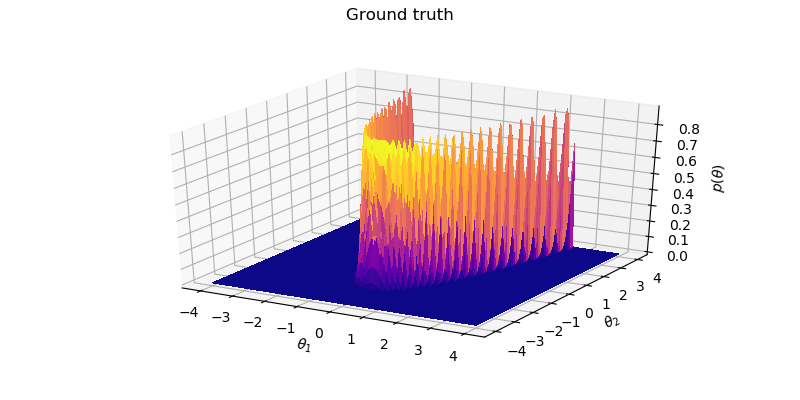

<IPython.core.display.Javascript object>


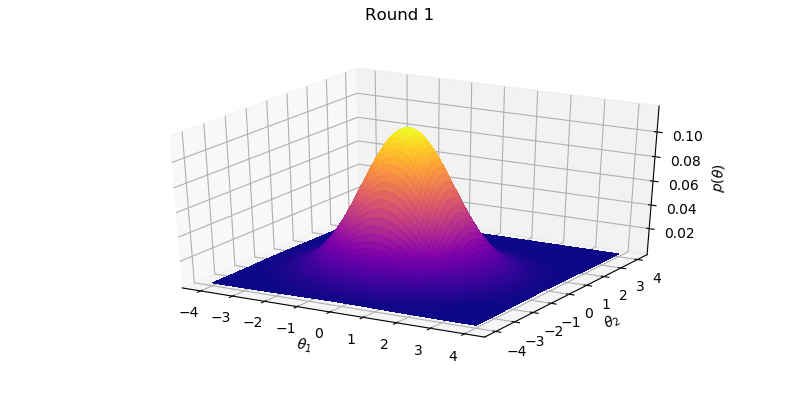

<IPython.core.display.Javascript object>


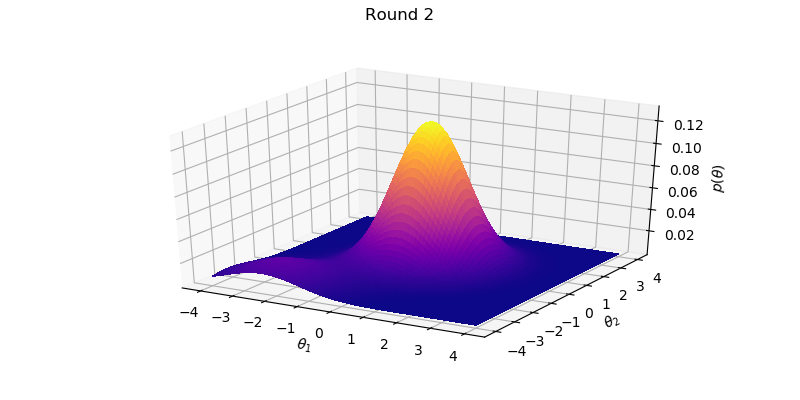

In [7]:
plot_pdf_2d(default_params, gt, "Ground truth");

for i, p in enumerate(posteriors):
    plot_pdf_2d(default_params, p, "Round {}".format(i+1));